## Cuadrados mínimos mediante descenso por gradiente

En esta sección, aplicaremos gradiente descendente para resolver un problema de regresión lineal en el dataset *California Housing*, proporcionado por la biblioteca `sklearn`. Este dataset contiene información sobre características demográficas y económicas de diferentes regiones de California, con el objetivo de predecir el valor medio de las viviendas (*MedHouseVal*).

El objetivo principal será encontrar un modelo lineal que mapee las características demográficas para inferir el valor medio de las viviendas utilizando los siguientes métodos numéricos:

- **Cuadrados mínimos con pseudoinversa**: que proporciona una solución analítica exacta para los mínimos cuadrados ordinarios.
- **Cuadrados mínimos mediante el gradiente descendente**: que calcula una solución aproximada mediante optimización iterativa.

### Descripción del problema

La regresión lineal busca minimizar la función objetivo del error cuadrático medio (ECM) de las predicciones $\hat{y} = Xw$, definido como:

$$
ECM(w) = \frac{1}{n} \|y - Xw\|^2_2,
$$

donde:

- $X \in \mathbb{R}^{n \times (d+1)}$ es la matriz de características con $n$ muestras y $d$ atributos, con una columna extra de unos para dar cuenta de la ordenada al origen.
- $y \in \mathbb{R}^n$ es el vector de valores objetivo (valor medio de las viviendas).
- $w \in \mathbb{R}^{d+1}$ es el vector de coeficientes incógnita (variables de decisión) a encontrar mediante la optimización.

Se debe particionar el dataset en un 80% de las muestras aleatoriamente como conjunto de entrenamiento y un 20% como conjunto de testeo. Adicionalmente, las columnas de atributos se deben estandarizar (es decir, restarles su media y dividir por la desviación estándar, $v \to \frac{v - \mu}{\sigma}$), calculando las medias y las desviaciones ($\mu$ y $\sigma$) únicamente a partir de las muestras del conjunto de entrenamiento.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from scipy.linalg import svd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset
housing = fetch_california_housing()
X = housing.data
y = housing.target

# La regresión lineal busca minimizar la funcion objetivo del error cuadrático medio (ECM) de las predicciones ˆy = Xw, definido como:
def ECM(w, X, y, n):
    return 1/n * np.linalg.norm(y - X @ w) ** 2

# Agregar columna de unos para el término independiente
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Particionar el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Estandarizar las características usando solo el conjunto de entrenamiento
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)
std[std == 0] = 1  # Evitar división por cero
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std



### Pseudoinversa

Implementen la solución analítica de mínimos cuadrados utilizando la fórmula:

$$
w = (X^\top X)^{-1} X^\top y.
$$

(Esta también puede escribirse en función de la descomposición SVD de la matriz $X$).

In [2]:
# Implementar la solución analítica de mínimos cuadrados usando pseudoinversa
w_analitico = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Calcular el error cuadrático medio en entrenamiento y prueba
n_train = X_train.shape[0]
n_test = X_test.shape[0]
ecm_train_analitico = ECM(w_analitico, X_train, y_train, n_train)
ecm_test_analitico = ECM(w_analitico, X_test, y_test, n_test)

print("Solución analítica de mínimos cuadrados con Pseudoinversa:")
print(f"ECM Entrenamiento: {ecm_train_analitico:.4f}")
print(f"ECM Prueba: {ecm_test_analitico:.4f}")

Solución analítica de mínimos cuadrados con Pseudoinversa:
ECM Entrenamiento: 0.5179
ECM Prueba: 0.5559



### Gradiente descendente

Implementen el algoritmo de gradiente descendente para minimizar el error cuadrático medio:

$$
w_{t+1} = w_t - \eta \nabla ECM(w_t),
$$

¿Es el ECM una función convexa?

Empleen la tasa de aprendizaje $\eta = \frac{1}{\sigma_1^2}$, donde $\sigma_1$ es el primer valor singular de la matriz $X$. ¿Por qué tiene sentido utilizar este valor?

In [3]:
# Implementar el algoritmo de gradiente decreciente para minimizar el error cuadratico medio

# Calcular el valor singular máximo de X_train
_, S, _ = svd(X_train, full_matrices=False)
sigma1 = S[0]

# Definir tasa de aprendizaje
eta = 1 / sigma1**2

# Inicializar parámetros
w_grad = np.zeros(X_train.shape[1])
iterations = 1000

# Almacenar el error en cada iteración
train_errors_grad = []
test_errors_grad = []

for i in range(iterations):
    # Calcular gradiente
    gradient = (2 / n_train) * X_train.T @ (X_train @ w_grad - y_train)
    # Actualizar parámetros
    w_grad -= eta * gradient
    # Calcular y almacenar el error
    ecm_train_grad = ECM(w_grad, X_train, y_train, n_train)
    ecm_test_grad = ECM(w_grad, X_test, y_test, n_test)
    train_errors_grad.append(ecm_train_grad)
    test_errors_grad.append(ecm_test_grad)

# Imprimir resultados finales
print("Solución mediante Gradiente Descendente:")
print(f"ECM Entrenamiento final: {train_errors_grad[-1]:.4f}")
print(f"ECM Prueba final: {test_errors_grad[-1]:.4f}")

Solución mediante Gradiente Descendente:
ECM Entrenamiento final: 5.0648
ECM Prueba final: 4.9798



### Análisis

- Comparen la solución obtenida por la pseudoinversa con la solución iterativa del gradiente descendente para distintos valores de $\eta$.


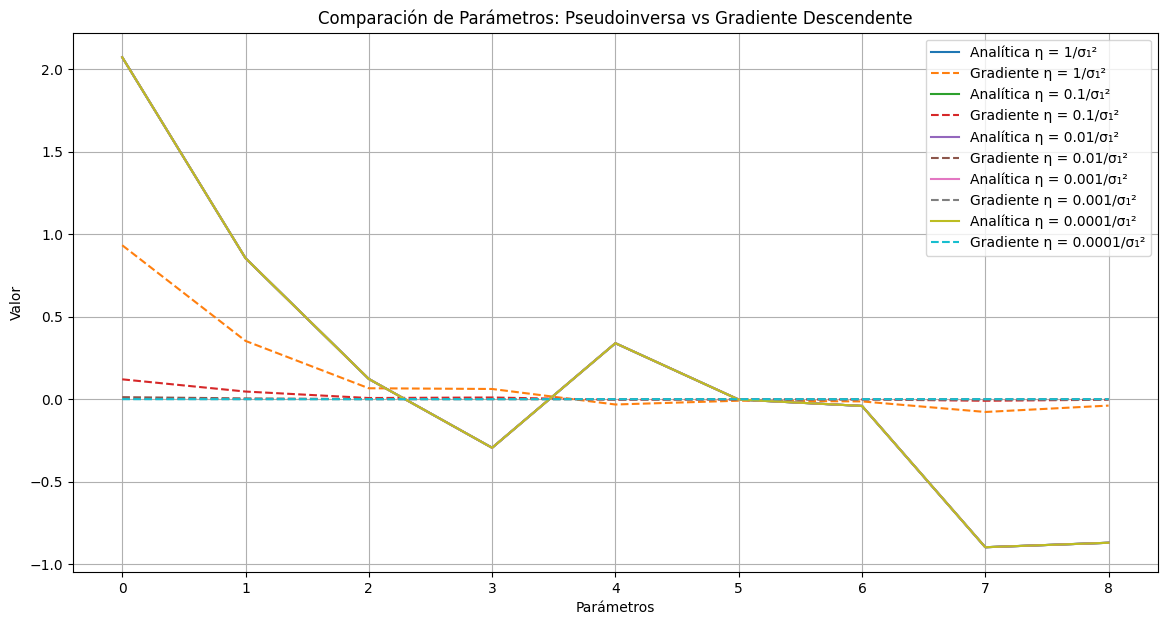

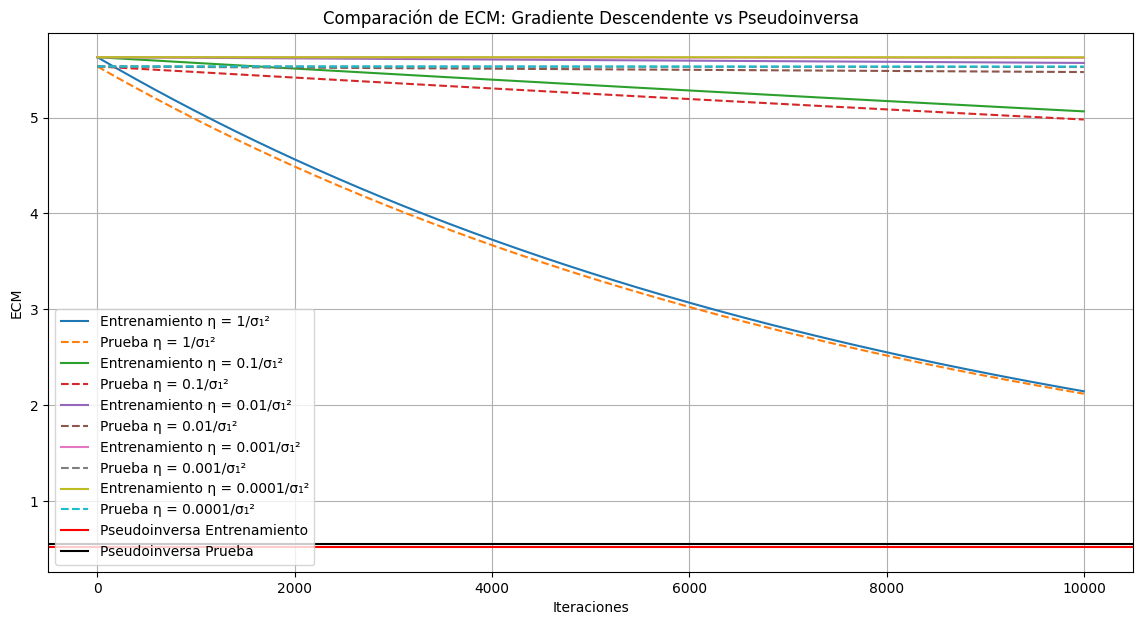


Comparación de ECM final:
Pseudoinversa - ECM Entrenamiento: 0.517933, ECM Prueba: 0.555892
η = 1/σ₁²
ECM Entrenamiento final: 2.144530
ECM Prueba final: 2.119071
Iteraciones para convergencia: 10000
η = 0.1/σ₁²
ECM Entrenamiento final: 5.064841
ECM Prueba final: 4.979838
Iteraciones para convergencia: 10000
η = 0.01/σ₁²
ECM Entrenamiento final: 5.570127
ECM Prueba final: 5.475021
Iteraciones para convergencia: 10000
η = 0.001/σ₁²
ECM Entrenamiento final: 5.623748
ECM Prueba final: 5.527572
Iteraciones para convergencia: 10000
η = 0.0001/σ₁²
ECM Entrenamiento final: 5.629143
ECM Prueba final: 5.532859
Iteraciones para convergencia: 10000


In [4]:
etas = [1 / sigma1**2, 0.1 / sigma1**2, 0.01 / sigma1**2, 0.001 / sigma1**2, 0.0001 / sigma1**2]
eta_labels = ['1/σ₁²', '0.1/σ₁²', '0.01/σ₁²', '0.001/σ₁²', '0.0001/σ₁²']

iterations = 10000
n_features = X_train.shape[1]

w_analiticos = []
w_gradientes = []

for eta in etas:
    w_analitico = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    w_analiticos.append(w_analitico)

    w_gradiente_decreciente = np.zeros(n_features)
    for _ in range(iterations):
        # Calcular gradiente
        gradient = (2 / n_train) * X_train.T @ (X_train @ w_gradiente_decreciente - y_train)
        # Actualizar parámetros
        w_gradiente_decreciente -= eta * gradient
    
    w_gradientes.append(w_gradiente_decreciente.copy())

plt.figure(figsize=(14, 7))
for idx, eta in enumerate(etas):
    plt.plot(w_analiticos[idx], label=f'Analítica η = {eta_labels[idx]}')
    plt.plot(w_gradientes[idx], linestyle='--', label=f'Gradiente η = {eta_labels[idx]}')

plt.xlabel('Parámetros')
plt.ylabel('Valor')
plt.title('Comparación de Parámetros: Pseudoinversa vs Gradiente Descendente')
plt.legend()
plt.grid(True)
plt.show()

# Grafico de comparacion de pseudoinversa y gradiente decreciente usando ecm

tolerancia = 1e-6  # Definir tolerancia de convergencia
convergencia_iters = []

# Almacenar errores para cada eta
all_train_errors_grad = []
all_test_errors_grad = []

for eta in etas:
    w_gradiente_decreciente = np.zeros(X_train.shape[1])
    train_errors_grad = []
    test_errors_grad = []

    for _ in range(iterations):
        # Calcular gradiente
        gradient = (2 / n_train) * X_train.T @ (X_train @ w_gradiente_decreciente - y_train)
        # Actualizar parámetros
        w_gradiente_decreciente -= eta * gradient
        # Calcular y almacenar el error
        ecm_train_grad = ECM(w_gradiente_decreciente, X_train, y_train, n_train)
        ecm_test_grad = ECM(w_gradiente_decreciente, X_test, y_test, n_test)
        train_errors_grad.append(ecm_train_grad)
        test_errors_grad.append(ecm_test_grad)

    all_train_errors_grad.append(train_errors_grad)
    all_test_errors_grad.append(test_errors_grad)

    # Calcular iteraciones para convergencia
    convergencia = next((i for i, e in enumerate(train_errors_grad) if e < tolerancia), iterations)
    convergencia_iters.append(convergencia)

# Graficar ECM para diferentes valores de eta
plt.figure(figsize=(14, 7))
for idx, eta in enumerate(etas):
    plt.plot(range(iterations), all_train_errors_grad[idx], label=f'Entrenamiento η = {eta_labels[idx]}')
    plt.plot(range(iterations), all_test_errors_grad[idx], linestyle='--', label=f'Prueba η = {eta_labels[idx]}')

# Líneas horizontales para la solución de pseudoinversa
plt.axhline(y=ecm_train_analitico, color='r', linestyle='-', label='Pseudoinversa Entrenamiento')
plt.axhline(y=ecm_test_analitico, color='k', linestyle='-', label='Pseudoinversa Prueba')

plt.xlabel('Iteraciones')
plt.ylabel('ECM')
plt.title('Comparación de ECM: Gradiente Descendente vs Pseudoinversa')
plt.legend()
plt.grid(True)
plt.show()

# Comparar ECM final entre pseudoinversa y gradiente descendente
ecm_final_train = [errors[-1] for errors in all_train_errors_grad]
ecm_final_test = [errors[-1] for errors in all_test_errors_grad]

print("\nComparación de ECM final:")
print(f"Pseudoinversa - ECM Entrenamiento: {ecm_train_analitico:.6f}, ECM Prueba: {ecm_test_analitico:.6f}")
for idx, eta in enumerate(etas):
    print(f"η = {eta_labels[idx]}")
    print(f"ECM Entrenamiento final: {ecm_final_train[idx]:.6f}")
    print(f"ECM Prueba final: {ecm_final_test[idx]:.6f}")
    print(f"Iteraciones para convergencia: {convergencia_iters[idx]}")


- Muestren el error en el conjunto de entrenamiento y de prueba frente al número de iteraciones para gradiente descendente.


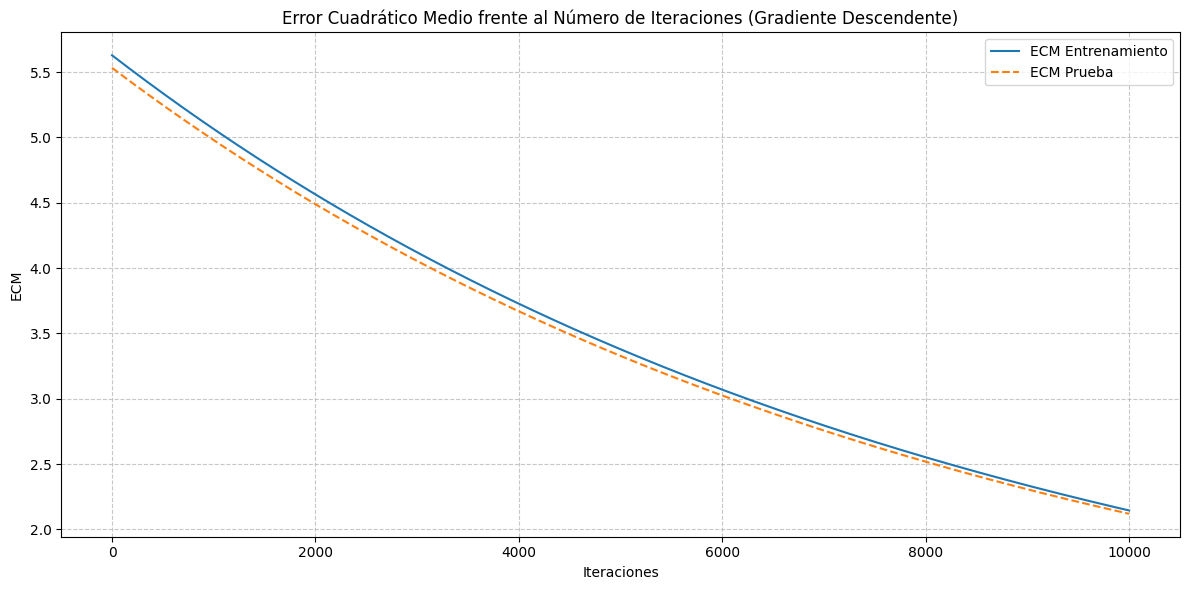

In [5]:
# Seleccionar los errores calculados previamente para η = 1/σ₁²
train_errors = all_train_errors_grad[0]
test_errors = all_test_errors_grad[0]

# Graficar el ECM frente a las iteraciones
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_errors)), train_errors, label='ECM Entrenamiento')
plt.plot(range(len(test_errors)), test_errors, label='ECM Prueba', linestyle='--')
plt.xlabel('Iteraciones')
plt.ylabel('ECM')
plt.title('Error Cuadrático Medio frente al Número de Iteraciones (Gradiente Descendente)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
